## sigMF RF classification; 12 classes

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import glob
import json
from os import walk
import pickle
import json
import pathlib
import random
from timeit import default_timer as timer
import time
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
global GPU, fft, Fs, center_freq, fft_val, Fs_test, loss, batches, eps, var_noise, mean_noise, top
global c1_coeff, c2_coeff, a, r1_c1, r2_c1, r1_c2, r2_c2, compare
a = 1
r1_c2 = 1
r2_c2 = 2
top = .995
var_noise = 8.78e-09
mean_noise = 1 # not used
eps = 1e-15
Fs = 1000000
fft = 1024
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz
center_freq_live = 428.00e6 # when SDR doing 25MSPS with center at 428MHz
batches = 64
plt.style.use('default')
GPU = 0
device = torch.device('cuda:0')
print('Torch version =', torch.__version__, 'CUDA version =', torch.version.cuda)
print('CUDA Device:', device)
print('Is cuda available? =',torch.cuda.is_available())

Torch version = 1.6.0 CUDA version = 10.2
CUDA Device: cuda:0
Is cuda available? = True


In [2]:
r2_c2

2

In [3]:
!. /home/david/prefix-3.8/setup_env.sh

#### Machine paths

In [4]:
path_ram = "/home/david/sigMF_ML/RF/ramdisk/"
path_usrp = "/home/david/prefix-3.8/"
path = "/home/david/sigMF_ML/RF/RF_class/data/" # ACE
path_val1 = "/home/david/sigMF_ML/RF/RF_class/data_val1/" # fft_center    - class 9
path_val2 = "/home/david/sigMF_ML/RF/RF_class/data_val2/" # light switch - class 10
path_val3 = "/home/david/sigMF_ML/RF/RF_class/data_val3/" # clickndig     - class 5
path_val4 = "/home/david/sigMF_ML/RF/RF_class/data_val4/" # GD55          - class 1
path_val5 = "/home/david/sigMF_ML/RF/RF_class/data_val5/" # lora125       - class 0
path_val6 = "/home/david/sigMF_ML/RF/RF_class/data_val6/" # lora250       - class 7
path_val7 = "/home/david/sigMF_ML/RF/RF_class/data_val7/" # NFM           - class 2
path_val8 = "/home/david/sigMF_ML/RF/RF_class/data_val8/" # sado          - class 6
path_val9 = "/home/david/sigMF_ML/RF/RF_class/data_val9/" # TYT           - class 3
path_val10 = "/home/david/sigMF_ML/RF/RF_class/data_val10/" # vodeson     - class 4
path_val11 = "/home/david/sigMF_ML/RF/RF_class/data_val11/" # white noise - class 8
path_val12 = "/home/david/sigMF_ML/RF/RF_class/data_val12/" # ysf        - class 11
path_fig = "/home/david/sigMF_ML/RF/RF_class/" # ACE
path_val = "/home/david/sigMF_ML/RF/RF_class/testing_data/" # ACE
path_save = "/home/david/sigMF_ML/RF/RF_class/saved/" # ACE
path_test = "/home/david/sigMF_ML/RF/RF_class/testing_data/" # ACE
path_test_1msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_1msps/" # ACE
path_test_5msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_5msps/" # ACE
path_test_10msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_10msps/" # ACE
path_test_25msps = "/home/david/sigMF_ML/RF/RF_class/testing_data_25msps/" # ACE
print(path)

/home/david/sigMF_ML/RF/RF_class/data/


## Functions 

In [8]:
# START OF FUNCTIONS ****************************************************
def meta_encoder(meta_list, num_classes): 
    a = np.asarray(meta_list, dtype=int)
#    print('a = ', a)
    return a 

def save_model(epoch,loss):
    rf_model = 'ResNet50_2ch_20210415_25msps_autosave'
    PATH = path_save+rf_model
    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,}, PATH)   
    
def load_model():
    rf_model = 'ResNet50_2ch_20210415_25msps_autosave'
    PATH = path_save+rf_model
    device = torch.device("cuda:0")
    model = resnet50(2, 12)
    model.load_state_dict(torch.load(PATH))
    model.to(device)
    model.eval()     

def gpu_test_file(db):
    if (msps == 1):
        w1 = fft
    elif (msps == 5):
        w1 = fft*1
    elif (msps == 10):
        w1 = fft*1        
    elif (msps == 25):
        w1 = fft*1 
    print('gpu_test file function')    
    I = db[0::2]
    Q = db[1::2]
    w = fft*msps
    print('Sample Rate = ',w,'MSPS')
    den = 2
    print('window length = ', w1)
    win = torch.hann_window(w1, periodic=True, dtype=None, layout=torch.strided, requires_grad=False).cuda(GPU)
    I_stft = torch.stft(torch.tensor(I).cuda(GPU), n_fft=fft, hop_length=fft//den, win_length=w1, window=win, center=True, normalized=True, onesided=True)
    Q_stft = torch.stft(torch.tensor(Q).cuda(GPU), n_fft=fft, hop_length=fft//den, win_length=w1, window=win, center=True, normalized=True, onesided=True)
    I_mag = torch.abs(torch.sqrt(I_stft[:,:,0]**2+I_stft[:,:,1]**2))
    Q_mag = torch.abs(torch.sqrt(Q_stft[:,:,0]**2+Q_stft[:,:,1]**2))     
    I_mag = torch.unsqueeze(I_mag, dim=2)
    Q_mag = torch.unsqueeze(Q_mag, dim=2)   
#     print('I shape =', I_stft.shape, 'Q shape = ', Q_stft.shape )
#     print('I_mag shape =', I_mag.shape, 'Q_mag shape = ', Q_mag.shape )
    Z_stft = torch.cat((I_mag,Q_mag),2)
#     Z_stft = torch.cat((Z_stft[fft//2:,:,:],Z_stft[:fft//2,:,:])) # NOT SURE I NEED TO DO THIS...
#     print('gpu_test file Z shape =', Z_stft.shape)
    Z_stft = Z_stft[fft//2:,:,:] # throw bottom 1/2 away
    print('FINAL gpu_test FILE IQ shape =', Z_stft.shape)
    torch.cuda.empty_cache()
    return Z_stft # Returning 2D

def gpu_test_live(db,msps):
    if (msps == 1):
        w1 = fft
    elif (msps == 5):
        w1 = fft*1
    elif (msps == 10):
        w1 = fft*1        
    elif (msps == 25):
        w1 = fft*1     
    print('gpu_test live function')    
#     I = db[0:10000000:2]
#     Q = db[1:10000000:2]    
    I = db[0::2]
    Q = db[1::2]
    print('I length = ', len(I))
    print('Q length = ', len(Q))
    w = fft*msps
    print(w,'MSPS')
    den = 2
    win = torch.hann_window(w1, periodic=True, dtype=None, layout=torch.strided, requires_grad=False).cuda(GPU)
    I_stft = torch.stft(torch.tensor(I).cuda(GPU), n_fft=w, hop_length=w//den, win_length=w1, window=win, center=True, normalized=True, onesided=True)
    Q_stft = torch.stft(torch.tensor(Q).cuda(GPU), n_fft=w, hop_length=w//den, win_length=w1, window=win, center=True, normalized=True, onesided=True)
    I_mag = torch.abs(torch.sqrt(I_stft[:,:,0]**2+I_stft[:,:,1]**2))
    Q_mag = torch.abs(torch.sqrt(Q_stft[:,:,0]**2+Q_stft[:,:,1]**2))      
    I_mag = torch.unsqueeze(I_mag, dim=2)
    Q_mag = torch.unsqueeze(Q_mag, dim=2)  
    Z_stft = torch.cat((I_mag,Q_mag),2)
    print('gpu_test live IQ shape =', Z_stft.shape)
#     Z_stft = torch.cat((Z_stft[w//2:,:,:],Z_stft[:w//2,:,:])) # NOT SURE I NEED TO DO THIS...
    Z_stft = Z_stft[:w//2,:,:]# throw bottom 1/2 away
    print('FINAL gpu_test LIVE IQ shape =', Z_stft.shape)
    return Z_stft # Returning 2D and plot
   
def iq_read(data_files): # USING GPU to perform STFT
    print('iq_read function**********')
    data_IQ_list = []
    data_IQ_temp = []
    for file in data_files:
        db = np.fromfile(file, dtype="float32")
#         stft = gpu(db).detach().cpu().numpy()
        print('iq_read function')
        stft, stft_plot = gpu_test_file(db)
        stft = stft.detach().cpu().numpy()
        stft_plot = stft_plot.detach().cpu().numpy()
        stft_plot = 10*np.log10(np.abs(stft_plot+eps))
        plt.imshow(stft_plot)
        plt.pcolormesh(stft_plot)
#         plt.imshow(stft, aspect='auto', origin='lower')
        plt.show()
        data_IQ_temp.append(stft)
    data_IQ_list = np.array(data_IQ_temp)
    return data_IQ_list

def iq_read_test_file(data_files): # USING GPU to perform STFT
    data_IQ_list = []
    data_IQ_temp = []
    print('iq_read_test file')
    for file in data_files:
        db = np.fromfile(file, dtype="float32")
        stft = gpu_test_file(db)
        stft_plot = 20*np.log10(np.abs(stft[:,:,0].detach().cpu().numpy()+eps))
        print('imshow method')
        plt.imshow(stft_plot, vmin=-70, vmax=5, aspect='auto', origin='lower')
        plt.show()
        data_IQ_temp.append(stft.detach().cpu().numpy())
    data_IQ_list = np.array(data_IQ_temp)
    return data_IQ_list


def iq_read_test_live(data_files,msps): # USING GPU to perform STFT
#     iq_cpu_plot(data_files) #checking with cpu complex plotting
    data_IQ_list = []
    data_IQ_temp = []
    print('iq_read_test live')
    for file in data_files:
        db = np.fromfile(file, dtype="float32")
        stft = gpu_test_live(db,msps)
        # *************************************************************************
        stft_plot = 20*np.log10(np.abs(stft[:,:,0].detach().cpu().numpy()+eps))
        print('iq_read_test live imshow method')
        plt.imshow(stft_plot, vmin=-70, vmax=5, aspect='auto', origin='lower')
        plt.show()
        # *************************************************************************
        data_IQ_temp.append(stft.detach().cpu().numpy())
    data_IQ_list = np.array(data_IQ_temp)
    return data_IQ_list


def read_meta(meta_files):
    meta_list = []
    for meta in meta_files:
        all_meta_data = json.load(open(meta))
        meta_list.append(all_meta_data['global']["core:class"])
    meta_list = list(map(int, meta_list))
    return meta_list

def read_num_val(x):
    x = len(meta_list_val)
    return x

#**************************** Print historgram subplots ******************************
def histo_plots(inputs):
    fig=plt.figure(figsize=(8,8))
    ncols = 2
    nrows = 2
    print('make torch inputs')
    print('inputs shape for histogram1 = ', inputs.shape)
    inputs = 10*np.log10(np.abs(inputs.cpu()+eps))
    for x in range(4):
#         print('x = ', x, 'inputs shape for histogram2 = ', inputs[:,:,x].shape)
        flat_inputs = torch.flatten(inputs[:,:,x], start_dim=0, end_dim=-1).numpy()
#         print('type = ', type(flat_inputs))
#         print('x = ', x, 'flat_input max = ', np.amax(flat_inputs))
#         print('inputs are: ', flat_inputs.shape)
        fig.add_subplot(nrows, ncols, x+1)
        plt.hist(flat_inputs, bins=5000)
        plt.gca().set(title='Frequency Histogram', ylabel='Frequency');
        plt.xlim(-100, 10)
#         plt.ylim(0, 40000)
    return flat_inputs
#*************************************************************************************    
#**************************** Print historgram subplots ******************************
def histo_stats(inputs):
#     print('make torch inputs')
#     print('inputs shape for histogram1 = ', inputs.shape)
    mean = np.zeros(4)
    std = np.zeros(4)
    for x in range(4):
#         print('x = ', x, 'inputs shape for histogram2 = ', inputs[:,:,x].shape)
        flat_inputs = torch.flatten(inputs[:,:,x], start_dim=0, end_dim=-1).numpy()
#         print('inputs are: ', flat_inputs.shape)
        mean[x] = flat_inputs.mean()
        std[x] = flat_inputs.std()
#         print('mean = ', mean, 'std = ', std)
    return mean, std
#**************************** Print historgram freq stats ******************************
def histo_stats_freq_file(inputs,msps):
    mean = inputs.mean()
    std = inputs.std()
    print("mean Freq = {0:9,.2f}".format(mean))
    print("std Freq = {0:9,.2f}".format(std))
    print('length of inputs = ', len(inputs))
#     plt.hist(inputs, 30, facecolor='blue', align='mid')
    if (msps==25):
        plt.hist(inputs, 30, range=[428.0, 440.0], facecolor='blue', align='mid')
    elif (msps==1):
        plt.hist(inputs, 30, range=[433.65, 434.15], facecolor='blue', align='mid')
    elif (msps==5):
        plt.hist(inputs, 30, range=[433.00, 435.50], facecolor='blue', align='mid')         
    elif (msps==10):
        plt.hist(inputs, 30, range=[433.00, 438.00], facecolor='blue', align='mid')        
    else:
        print('WRONG SAMPLE RATE CHOSEN')
    plt.gca().set(title='Frequency Histogram', ylabel='Frequency'); 
    plt.show()
def histo_stats_freq_live(inputs,msps):
    mean = inputs.mean()
    std = inputs.std()
    print("mean Freq = {0:9,.2f}".format(mean))
    print("std Freq = {0:9,.2f}".format(std))
    print('length of inputs = ', len(inputs))
#     plt.hist(inputs, 30, facecolor='blue', align='mid')
    if (msps==25):
        plt.hist(inputs, 30, range=[428.0, 440.0], facecolor='blue', align='mid')
    elif (msps==1):
        plt.hist(inputs, 30, range=[433.65, 434.15], facecolor='blue', align='mid')
    elif (msps==5):
        plt.hist(inputs, 30, range=[433.00, 435.50], facecolor='blue', align='mid')          
    elif (msps==10):
        plt.hist(inputs, 30, range=[433.00, 438.00], facecolor='blue', align='mid')         
    else:
        print('WRONG SAMPLE RATE CHOSEN')
    plt.gca().set(title='Frequency Histogram', ylabel='Frequency'); 
    plt.show()
# END OF FUNCTIONS ******************************************************

In [9]:
from functools import partial
from dataclasses import dataclass
from collections import OrderedDict

In [10]:
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False) 

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels, self.out_channels =  in_channels, out_channels
        self.blocks = nn.Identity()
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

In [12]:
class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(OrderedDict(
        {
            'conv' : nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            'bn' : nn.BatchNorm2d(self.expanded_channels)
            
        })) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

In [13]:
def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(OrderedDict({'conv': conv(in_channels, out_channels, *args, **kwargs), 
                          'bn': nn.BatchNorm2d(out_channels) }))

In [14]:
class ResNetBasicBlock(ResNetResidualBlock):
    expansion = 1
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation(),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )

In [15]:
class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
             activation(),
             conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
             activation(),
             conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )

In [16]:
class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x

In [17]:
class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by increasing different layers with increasing features.
    """
    def __init__(self, in_channels=3, blocks_sizes=[64, 128, 256, 512], deepths=[2,2,2,2], 
                 activation=nn.ReLU, block=ResNetBasicBlock, *args,**kwargs):
        super().__init__()
        
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation, 
                        block=block,  *args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x

In [18]:
class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x

In [19]:
class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [20]:
def resnet18(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[2, 2, 2, 2])

def resnet34(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[3, 4, 6, 3])

def resnet50(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 6, 3])

def resnet101(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 23, 3])

def resnet152(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 8, 36, 3])

In [21]:
from torchsummary import summary

# model = resnet50(4, 12)
# summary(model.cuda(GPU), (4, 224, 224))

In [22]:
from torch.utils.data import Dataset

In [23]:
class RFDataset(Dataset):
    def __init__(self, root_path, limit=None):
        print(root_path)
        self.root_path = root_path
        self.list_of_all_pickles = sorted(pathlib.Path(root_path).rglob('*/chopped-data-224-224/*.pickle'))
        if limit:
            rng = np.random.default_rng(0)
            self.list_of_all_pickles = rng.choice(self.list_of_all_pickles, size=limit, replace=False)
        self.get_class = dict()
        class_folders = list(pathlib.Path(root_path).glob('*/'))
        for class_folder in class_folders:
            class_index = -1
            metadata_path = list(class_folder.rglob('*.sigmf-meta'))[0]
            with open(metadata_path) as fp:
                metadata = json.load(fp)
                class_index = int(metadata["global"]["core:class"])
            self.get_class[str(class_folder.stem)] = class_index


    def __len__(self):
        return len(self.list_of_all_pickles)

    def __getitem__(self, idx):
        filepath = self.list_of_all_pickles[idx]
        with open(filepath, 'rb') as fp:
            tensor = pickle.load(fp)['bounded']
        foldername = filepath.parts[7]
        label = self.get_class[foldername]

        #return (tensor, label) # this is a tuple
        return {'data': tensor, 'label': label}

#### Evaluation dataset loader

In [24]:
val_patches = 2000
rf_dataset1 = RFDataset(path_val1, limit=val_patches)
val1_data = data.DataLoader(rf_dataset1, batch_size=batches, shuffle=True)
rf_dataset2 = RFDataset(path_val2, limit=val_patches)
val2_data = data.DataLoader(rf_dataset2, batch_size=batches, shuffle=True)
rf_dataset3 = RFDataset(path_val3, limit=val_patches)
val3_data = data.DataLoader(rf_dataset3, batch_size=batches, shuffle=True)
rf_dataset4 = RFDataset(path_val4, limit=val_patches)
val4_data = data.DataLoader(rf_dataset4, batch_size=batches, shuffle=True)
rf_dataset5 = RFDataset(path_val5, limit=val_patches)
val5_data = data.DataLoader(rf_dataset5, batch_size=batches, shuffle=True)
rf_dataset6 = RFDataset(path_val6, limit=val_patches)
val6_data = data.DataLoader(rf_dataset6, batch_size=batches, shuffle=True)
rf_dataset7 = RFDataset(path_val7, limit=val_patches)
val7_data = data.DataLoader(rf_dataset7, batch_size=batches, shuffle=True)
rf_dataset8 = RFDataset(path_val8, limit=val_patches)
val8_data = data.DataLoader(rf_dataset8, batch_size=batches, shuffle=True)
rf_dataset9 = RFDataset(path_val9, limit=val_patches)
val9_data = data.DataLoader(rf_dataset9, batch_size=batches, shuffle=True)
rf_dataset10 = RFDataset(path_val10, limit=val_patches)
val10_data = data.DataLoader(rf_dataset10, batch_size=batches, shuffle=True)
rf_dataset11 = RFDataset(path_val11, limit=val_patches)
val11_data = data.DataLoader(rf_dataset11, batch_size=batches, shuffle=True)
rf_dataset12 = RFDataset(path_val12, limit=val_patches)
val12_data = data.DataLoader(rf_dataset12, batch_size=batches, shuffle=True)

/home/david/sigMF_ML/RF/RF_class/data_val1/
/home/david/sigMF_ML/RF/RF_class/data_val2/
/home/david/sigMF_ML/RF/RF_class/data_val3/
/home/david/sigMF_ML/RF/RF_class/data_val4/
/home/david/sigMF_ML/RF/RF_class/data_val5/
/home/david/sigMF_ML/RF/RF_class/data_val6/
/home/david/sigMF_ML/RF/RF_class/data_val7/
/home/david/sigMF_ML/RF/RF_class/data_val8/
/home/david/sigMF_ML/RF/RF_class/data_val9/
/home/david/sigMF_ML/RF/RF_class/data_val10/
/home/david/sigMF_ML/RF/RF_class/data_val11/
/home/david/sigMF_ML/RF/RF_class/data_val12/


#### list of loaders

In [25]:
val_data_list = [val1_data]
val_data_list.append(val2_data)
val_data_list.append(val3_data)
val_data_list.append(val4_data)
val_data_list.append(val5_data)
val_data_list.append(val6_data)
val_data_list.append(val7_data)
val_data_list.append(val8_data)
val_data_list.append(val9_data)
val_data_list.append(val10_data)
val_data_list.append(val11_data)
val_data_list.append(val12_data)
print('done')

done


## Training

In [26]:
def train_net(total):
    test_patch_total = 24000 # 120000
    compare = .7
    loss_plot = np.zeros(total)
    total_plot = np.zeros(total//5+1)
    batch_plot = np.zeros(len(training_data)*total//100)
    batch_indexer = 0
#     batch_sum = 0
    for epoch in tqdm(range(total), desc="Epoch"): 
        model.train()
        start = timer()
        for i, rf_data in enumerate(training_data, 0):
            inputs = rf_data['data']
            inputs = torch.squeeze(inputs, dim=1)
#             print('input1  = ', inputs.shape)
            inputs = inputs.permute(0,3,1,2).contiguous()
#             print('input before noise add  = ', inputs.shape)
            batch_dim, b, c, d = inputs.shape 
#             batch_sum = batch_sum + batch_dim
            # add som noise
#             c2 = torch.FloatTensor(a).uniform_(r1_c2, r2_c2) 
            C2 = 1
            for batch_num in range(batch_dim):
                inputs[batch_num,:,:,:] = inputs[batch_num,:,:,:] + (((var_noise*C2)**0.5)*torch.randn(1, 4, 224, 224))   
            #**************** take I and Q magnitudue only ***********
            I_temp = torch.abs(torch.sqrt(inputs[:,0,:,:]**2+inputs[:,1,:,:]**2))        
            I_temp = torch.unsqueeze(I_temp, dim=1)
            Q_temp = torch.abs(torch.sqrt(inputs[:,2,:,:]**2+inputs[:,3,:,:]**2))
            Q_temp = torch.unsqueeze(Q_temp, dim=1)
            inputs = torch.cat((I_temp,Q_temp),1)
#             print('inputs after noise add  = ', inputs.shape) 
            #*********************************************************  
            inputs = Variable(inputs.cuda(GPU))
            labels = rf_data['label']
            labels = labels.cuda(GPU)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        end = timer()
        batch_time = end - start
#         print('train total batches =', batch_sum)
        #***************************************************************************************
        print('batch time = ', batch_time)
        print('************************* start *************************')
        total_correct_patches = grand_total = 0
        start_test = timer()
        model.eval()
        for testing in val_data_list:
            t = train_val(testing)
            total_correct_patches = total_correct_patches + t           
        grand_total = total_correct_patches/test_patch_total
        batch_plot[batch_indexer] = grand_total*100
        batch_indexer = batch_indexer + 1
    #     print('Batch number = ', i, 'of', len(training_data))
        print('Total % correct {:.2f}%'.format(grand_total*100))         
        model.train 
        end_test = timer()
        test_time = end_test - start_test
        print('test time = ', test_time)
        print('*************************** end ***************************')
        #****************************************************************************************         
        save_model(epoch,loss)
        tqdm.write('___________________________________________')
        tqdm.write("Epoch {} Loss {:.10f} ".format(epoch+1, loss.data*1)) 
        tqdm.write('___________________________________________')        
    return loss_plot, batch_plot

#### Training Evaluation

In [27]:
def train_val(val_data):
    with torch.no_grad():
        total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
        c0 = c1 = c2 = c3 = c4 = c5 = c6 = c7 = c8 = c9 = 0
#         batch_sum = 0
        for i, rf_data in enumerate(val_data, 0): 
            inputs = rf_data['data']
            inputs = torch.squeeze(inputs, dim=1)
            inputs = inputs.permute(0,3,1,2).contiguous() 
            batch_dim, b, c, d = inputs.shape  
#             batch_sum = batch_sum + batch_dim
            # add som noise
#             c2 = torch.FloatTensor(a).uniform_(r1_c2, r2_c2)
            # bypass C2
            C2 = 1
            for batch_num in range(batch_dim):
                inputs[batch_num,:,:,:] = inputs[batch_num,:,:,:] + (((var_noise*c2)**0.5)*torch.randn(1, 4, 224, 224)*1)              
            #**************** take I and Q magnitudue only ***********
            I_temp = torch.abs(torch.sqrt(inputs[:,0,:,:]**2+inputs[:,1,:,:]**2))
            I_temp = torch.unsqueeze(I_temp, dim=1)
            Q_temp = torch.abs(torch.sqrt(inputs[:,2,:,:]**2+inputs[:,3,:,:]**2))
            Q_temp = torch.unsqueeze(Q_temp, dim=1)
            inputs = torch.cat((I_temp,Q_temp),1)
            #*********************************************************               
            inputs = Variable(inputs.cuda(GPU))
            labels = rf_data['label']
            labels = labels.cuda(GPU)
            optimizer.zero_grad() 
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1) 
            for b in range(len(predicted)):
                labels_temp = labels[b].detach().cpu().numpy()
                temp = predicted[b].detach().cpu().numpy()
                if (labels_temp==temp):
                    accumulated_corrects = accumulated_corrects+1
#         print('val total batches =', batch_sum)
    torch.cuda.empty_cache()
    return accumulated_corrects

## Inference Segmented Dataloader

In [28]:
# Inference Dataloader with labels
class inference_dataloader_segmented_live(data.Dataset):
    def __init__(self):
        self.dataPath = path
        self.num_classes = 12
        self.num_examples = 1 # use only 1 for semi-live inferencing
    def __getitem__(self, index):
        sigmf_data = np.array(data_IQ_list_val[index]) 
        print('sigmf_data = ', sigmf_data.shape)
        frequency, time, dims1 = sigmf_data.shape
        print('frequency = ', frequency, '  time = ', time)
        data_IQ = []
        data_IQ_temp2 = []
        seg_t = 224  
        seg_f = 224 
        seg_time = time//seg_t
        seg_freq = frequency//seg_f
        print('seg_time = ', seg_time, 'seg_freq = ', seg_freq)
        # Segment the time axis
        for j in range(seg_time): 
                # Segment the frequency axis
                for k in range(seg_freq): 
                    IQ = sigmf_data[seg_f*k:(seg_f)+seg_f*k,seg_t*j:(seg_t)+seg_t*j]
                    data_IQ_temp2.append(IQ)            
        data_IQ = np.array(data_IQ_temp2)
        print('data_IQ shape = ', data_IQ.shape)
        loop_counter, dim1, dim2, dim3 = data_IQ.shape
        TRUTH =  meta_encoder(meta_list_val, self.num_classes)
        TRUTH = TRUTH.astype(np.float32)
        return torch.from_numpy(data_IQ),torch.from_numpy(TRUTH), loop_counter, seg_freq
    def __len__(self):
        return self.num_examples 

In [29]:
# Inference Dataloader with labels
class inference_dataloader_segmented(data.Dataset):
    def __init__(self):
        self.dataPath = path
        self.num_classes = 12
        self.num_examples = 1
    def __getitem__(self, index):
        sigmf_data = np.array(data_IQ_list_val[index]) 
        print('sigmf_data = ', sigmf_data.shape)
        frequency, time, dims1 = sigmf_data.shape
        print('frequency = ', frequency, '  time = ', time)
        data_IQ = []
        data_IQ_temp2 = []
        seg_t = 224  
        seg_f = 224 
        seg_time = time//seg_t
        seg_freq = frequency//seg_f
        print('seg_time = ', seg_time, 'seg_freq = ', seg_freq)
        # Segment the time axis
        for j in range(seg_time): 
                # Segment the frequency axis
                for k in range(seg_freq): 
                    IQ = sigmf_data[seg_f*k:(seg_f)+seg_f*k,seg_t*j:(seg_t)+seg_t*j]
                    data_IQ_temp2.append(IQ)            
        data_IQ = np.array(data_IQ_temp2)
        print('data_IQ shape = ', data_IQ.shape)
        loop_counter, dim1, dim2, dim3 = data_IQ.shape
        TRUTH =  meta_encoder(meta_list_val, self.num_classes)
        TRUTH = TRUTH.astype(np.float32)
        return torch.from_numpy(data_IQ),torch.from_numpy(TRUTH), loop_counter, seg_freq
    def __len__(self):
        return self.num_examples 

### validation functions

In [30]:
def validation_read():    
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path_val)
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("validation file name = ", meta)
    # Load validation sigmf-data files
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read(data_files_validation)
    return data_IQ_list_val, meta_list_val

In [31]:
def testing_read():
    print('testing_read function')
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path_val)
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("testing file name = ", meta)
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read_test_file(data_files_validation)
    return data_IQ_list_val, meta_list_val

#### Changed to get test data from different directory

In [32]:
def inference_read(msps):    
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path_ram)
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("inference file name = ", meta)
    # Load validation sigmf-data files
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read_test_live(data_files_validation,msps)
    return data_IQ_list_val, meta_list_val

In [33]:
def inference_read_file(msps,path):    
    # Inference DATA READING ************************************************
    # read in validation IQ and meta data
    os.chdir(path)
    data_files_validation = sorted(glob.glob('*.sigmf-data'))
    meta_files_validation = sorted(glob.glob('*.sigmf-meta'))
    for meta in meta_files_validation:
        all_meta_data = json.load(open(meta))
        print("inference file name = ", meta)
    # Load validation sigmf-data files
    meta_list_val = read_meta(meta_files_validation)
    data_IQ_list_val = iq_read_test_live(data_files_validation,msps)
    return data_IQ_list_val, meta_list_val

In [34]:
    # inference ************************************************************
def testing_file(msps):    
        large_width = 400
        np.set_printoptions(precision=2,floatmode='fixed', linewidth=large_width)
        model.eval()
        V = data.DataLoader(inference_dataloader_segmented(), batch_size=1)
        start_frequency = (center_freq_file)
        match_freq = start_frequency
        print('start_frequency = ', start_frequency/1000000)
        freq_offset = 0       
        total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
        c0 = c1 = c2 = c3 = c4 = c5 = c6 = c7 = c8 = c9 = 0
#         total = 68
        with torch.no_grad():
            for i, rf_data in enumerate(V, 0):   
                accumulated_corrects = 0
                percent_correct = 0
                target_to_int = 0
                inputs, target, counter, seg_freq = rf_data 
                print('testing counter = ', counter, 'seg_freq =', seg_freq)
#**************************** Print segmented pics ***********************************
#                 stft_plot = np.squeeze(inputs, axis=0)
#                 fig=plt.figure(figsize=(8,8))
#                 ncols = 5
#                 nrows = 5
#                 range_plot = 1
#                 for x in range(1,22): # need to figure out how to not hard code this ********************* <-----
#                     stft_mean, stft_std = histo_stats(stft_plot[x,:,:,:])
#                     if (x>=range_plot and x<(range_plot+25)):
#                         stft_plot1 =  10*np.log10(np.abs(stft_plot[x, :, :, 0]+eps))
#                         stft_plot1 = np.squeeze(stft_plot1, axis=0)
#                         fig.add_subplot(nrows, ncols, x-range_plot+1)
#                         plt.imshow(stft_plot1, vmin=-70, vmax=5)
#                 plt.show()
#******************************************************************************************    
                freq_increment = (Fs*msps/2)/seg_freq.detach().cpu().numpy().item()
                print('freq_increment = ', freq_increment)
                print('TESTING inputs SHAPE = ', inputs.shape)
                target = Variable(target.cuda(GPU)) 
                print('input in   = ', inputs.shape)
                inputs = torch.squeeze(inputs, dim=0)
                print('input out  = ', inputs.shape)
                inputs = inputs.permute(0,3,1,2).contiguous()
                print('counter convert stuff = ', counter, type(counter.numpy()))
                inputs = Variable(inputs.cuda(GPU))
                print('permuted shape = ', inputs.shape)
                freq_count = 0 # keep track of array position
                freq_histo = np.zeros(counter.numpy())
                for j in range(counter):
                    inputs2 = inputs[j,:,:,:]
                    inputs2 = torch.unsqueeze(inputs2,0)
                    outputs = model(inputs2)
                    _, predicted = torch.max(outputs.data, 1) 
#******************************* Print prediction range to match pics above ***********        
#                     if (j>=range_plot and j<(range_plot+25)):                    
#                         print("j= ",j,' ',outputs.data.detach().cpu().numpy())
#                         print('prediction = ', predicted.detach().cpu().numpy())
#*************************************************************************************               
                    total = total +1  # Increment the total count
                    match_freq = match_freq + freq_offset*freq_increment
                    if (predicted.detach().cpu().numpy() == 0):
                        c0 = c0 + 1  
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 1):
                        c1 = c1 + 1
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 2):
                        c2 = c2 + 1
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 3):
                        c3 = c3 + 1
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 4):
                        c4 = c4 + 1
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 5):
                        c5 = c5 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 6):
                        c6 = c6 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 7):
                        c7 = c7 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 8):
                        noise = noise + 1
                    if (predicted.detach().cpu().numpy() == 9):
                        center_fft = center_fft + 1  
                    if (predicted.detach().cpu().numpy() == 10):
                        c8 = c8 + 1  
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 11):
                        c9 = c9 + 1 
                        freq_histo[j] = match_freq/1000000            
                    freq_offset = freq_offset + 1
                    if (freq_offset == seg_freq):
                        freq_offset = 0
                    match_freq = start_frequency
                torch.cuda.empty_cache()
                # complete ******************************************************
                freq_histo = np.ma.masked_equal(freq_histo, 0)
                histo_stats_freq_file(freq_histo,msps)
                denom = total-center_fft-noise
                print('************************* Probabilities ********************************')
                print('----------------------------WAVEFORMS-----------------------------------')
                if (denom == 0):
                    print('Nothing but noise')
                else:
                    print('LoRa 125 = {:.2f}%'.format(c0/denom*100))
                    print('GD55 DMR = {:.2f}%'.format(c1/denom*100))
                    print('NFM = {:.2f}%'.format(c2/denom*100))
                    print('TYT = {:.2f}'.format(c3/denom*100))
                    print('Vodeson Doorbell = {:.2f}%'.format(c4/denom*100))
                    print('clickndig = {:.2f}%'.format(c5/denom*100))
                    print('Sado doorbell = {:.2f}%'.format(c6/denom*100))
                    print('LoRa 250 = {:.2f}%'.format(c7/denom*100))
                    print('light switch = {:.2f}%'.format(c8/denom*100))
                    print('YSF = {:.2f}%'.format(c9/denom*100))
                print('------------------------------------------------------------------------')
                print('***************************** noise and fft ****************************')
                print('noise matches = ', noise)
                print('center fft matches = ', center_fft)
                print('TOTAL patch count = ', total)
                print('***************************** Finished *********************************')

In [35]:
    # inference ************************************************************
def testing_live(msps):    
        large_width = 400
        np.set_printoptions(precision=2,floatmode='fixed', linewidth=large_width)
        model.eval()
        V = data.DataLoader(inference_dataloader_segmented(), batch_size=1)
        start_frequency = (center_freq_live)
        match_freq = start_frequency
        print('start_frequency = ', start_frequency/1000000)
        freq_offset = 0       
        total = noise = center_fft = target_to_int = accumulated_corrects = percent_correct = 0
        c0 = c1 = c2 = c3 = c4 = c5 = c6 = c7 = c8 = c9 = 0
        with torch.no_grad():
            for i, rf_data in enumerate(V, 0):   
                accumulated_corrects = 0
                percent_correct = 0
                target_to_int = 0
                inputs, target, counter, seg_freq = rf_data 
                print('testing counter = ', counter, 'seg_freq =', seg_freq)
                print('seg_freq = ', seg_freq)
#**************************** Print segmented pics ***********************************
                stft_plot = np.squeeze(inputs, axis=0)
                fig=plt.figure(figsize=(8,8))
                ncols = 5
                nrows = 5
                range_plot = 1
                range_end = range_plot+5
                for x in range(1,51): # need to figure out how to not hard code this ********************* <-----
                    if (x>=range_plot and x<(range_end)):
                        stft_plot1 =  stft_plot[x, :, :, 1]
                        stft_plot1 =  10*np.log10(np.abs(stft_plot[x, :, :, 0]+eps))
                        fig.add_subplot(nrows, ncols, x-range_plot+1)
                        plt.imshow(stft_plot1, vmin=-70, vmax=5)
                plt.show()
#******************************************************************************************    
                freq_increment = (Fs*msps/2)/seg_freq.detach().cpu().numpy().item()
                print('freq_increment = ', freq_increment)
                print('TESTING inputs SHAPE = ', inputs.shape)
                target = Variable(target.cuda(GPU)) 
                print('input in   = ', inputs.shape)
                inputs = torch.squeeze(inputs, dim=0)
                print('input out  = ', inputs.shape)
                inputs = inputs.permute(0,3,1,2).contiguous()
                print('counter convert stuff = ', counter, type(counter.numpy()))
                inputs = Variable(inputs.cuda(GPU))
                print('permuted shape = ', inputs.shape)
                freq_count = 0 # keep track of array position
                freq_histo = np.zeros(counter.numpy())
                for j in range(counter):
                    inputs2 = inputs[j,:,:,:]
                    inputs2 = torch.unsqueeze(inputs2,0)
                    outputs = model(inputs2)
                    _, predicted = torch.max(outputs.data, 1) 
#******************************* Print prediction range to match pics above ***********        
#                     if (j>=range_plot and j<(range_end)):                    
# #                         print("j= ",j,' ',outputs.data.detach().cpu().numpy())
#                         print('prediction = ', predicted.detach().cpu().numpy())
#                         print('******************')
#*************************************************************************************              
                    total = total +1  # Increment the total count
                    match_freq = match_freq + freq_offset*freq_increment
                    if (predicted.detach().cpu().numpy() == 0):
                        c0 = c0 + 1  
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 1):
                        c1 = c1 + 1
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 2):
                        c2 = c2 + 1
                        freq_histo[j] = match_freq/1000000
                    if (predicted.detach().cpu().numpy() == 3):
                        c3 = c3 + 1
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 4):
                        c4 = c4 + 1
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 5):
                        c5 = c5 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 6):
                        c6 = c6 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 7):
                        c7 = c7 + 1 
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 8):
                        noise = noise + 1
                    if (predicted.detach().cpu().numpy() == 9):
                        center_fft = center_fft + 1  
                    if (predicted.detach().cpu().numpy() == 10):
                        c8 = c8 + 1  
                        freq_histo[j] = match_freq/1000000            
                    if (predicted.detach().cpu().numpy() == 11):
                        c9 = c9 + 1 
                        freq_histo[j] = match_freq/1000000            
                    freq_offset = freq_offset + 1
                    if (freq_offset == seg_freq):
                        freq_offset = 0
                    match_freq = start_frequency
                torch.cuda.empty_cache()
                # complete ******************************************************
                freq_histo = np.ma.masked_equal(freq_histo, 0)
                histo_stats_freq_live(freq_histo,msps)
                denom = total-center_fft-noise
                print('************************* Probabilities ********************************')
                print('----------------------------WAVEFORMS-----------------------------------')
                if (denom == 0):
                    print('Nothing but noise')
                else:
                    print('LoRa 125 = {:.2f}%'.format(c0/denom*100))
                    print('GD55 DMR = {:.2f}%'.format(c1/denom*100))
                    print('NFM = {:.2f}%'.format(c2/denom*100))
                    print('TYT = {:.2f}'.format(c3/denom*100))
                    print('Vodeson Doorbell = {:.2f}%'.format(c4/denom*100))
                    print('clickndig = {:.2f}%'.format(c5/denom*100))
                    print('Sado doorbell = {:.2f}%'.format(c6/denom*100))
                    print('LoRa 250 = {:.2f}%'.format(c7/denom*100))
                    print('light switch = {:.2f}%'.format(c8/denom*100))
                    print('YSF = {:.2f}%'.format(c9/denom*100))
                print('------------------------------------------------------------------------')
                print('***************************** noise and fft ****************************')
                print('noise matches = ', noise)
                print('center fft matches = ', center_fft)
                print('TOTAL patch count = ', total)
                print('***************************** Finished *********************************')

In [36]:
train_dataloader = RFDataset(path, limit=120000)

/home/david/sigMF_ML/RF/RF_class/data/


In [37]:
training_data = data.DataLoader(train_dataloader, batch_size=batches, shuffle=True)

## CUDA initialization

In [38]:
model = resnet50(2, 12) # number of input channels, number of classes
CUDA = torch.cuda.is_available()
if CUDA:
    model.cuda(GPU)
CUDA  

True

In [39]:
torch.cuda.empty_cache()

## Final training initialization

In [40]:
# momentum = .3
criterion = nn.CrossEntropyLoss()
lr= 1e-4
optimizer = optim.AdamW(model.parameters(), lr=lr)
# optimizer = optim.SGD(model.parameters(), lr=lr,momentum=momentum)
# optimizer = optim.RMSprop(model.parameters(), lr=lr,momentum=momentum)
# optimizer = optim.SGD(model.parameters(), lr=lr)
# training_data = data.DataLoader(rf_dataset, batch_size=batches, shuffle=True)
model.train()

ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBottleNeckBlock(
            (blocks): Sequential(
              (0): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU()
              (2): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [41]:
# VALIDATION ************************************************************
np.set_printoptions(threshold=np.inf)
calc = np.zeros([6])
averaging = 0
correct = 0
total = 0
# V = data.DataLoader(inference_dataloader_segmented(), batch_size=1, shuffle=True)
model.eval()

ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBottleNeckBlock(
            (blocks): Sequential(
              (0): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU()
              (2): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

### TRAIN Model

In [ ]:
total = 100
loss_plot,total_plot = train_net(total)

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

batch time =  946.1469759730026
************************* start *************************
Total % correct 98.41%
test time =  144.22196200599865
*************************** end ***************************


Epoch:   1%|          | 1/100 [18:10<29:59:44, 1090.75s/it]

___________________________________________
Epoch 1 Loss 0.0000918602 
___________________________________________
batch time =  912.6899661980024
************************* start *************************
Total % correct 75.30%
test time =  102.15643055699911
*************************** end ***************************


Epoch:   2%|▏         | 2/100 [35:06<29:04:38, 1068.14s/it]

___________________________________________
Epoch 2 Loss 0.0000202458 
___________________________________________
batch time =  898.3656834709982
************************* start *************************
Total % correct 78.31%
test time =  100.60363802999927
*************************** end ***************************


Epoch:   3%|▎         | 3/100 [51:45<28:13:32, 1047.55s/it]

___________________________________________
Epoch 3 Loss 0.1133899540 
___________________________________________
batch time =  935.3918590370013
************************* start *************************
Total % correct 98.33%
test time =  106.53624190700066
*************************** end ***************************


Epoch:   4%|▍         | 4/100 [1:09:08<27:53:39, 1046.03s/it]

___________________________________________
Epoch 4 Loss 0.0000136954 
___________________________________________
batch time =  908.2346221959997
************************* start *************************
Total % correct 98.29%
test time =  103.45090967899887
*************************** end ***************************


Epoch:   5%|▌         | 5/100 [1:26:00<27:20:08, 1035.88s/it]

___________________________________________
Epoch 5 Loss 0.0000010934 
___________________________________________
batch time =  904.2600348740016
************************* start *************************
Total % correct 98.48%
test time =  102.44029101100023
*************************** end ***************************


Epoch:   6%|▌         | 6/100 [1:42:47<26:49:24, 1027.28s/it]

___________________________________________
Epoch 6 Loss 0.0000065322 
___________________________________________
batch time =  904.904434475
************************* start *************************
Total % correct 98.55%
test time =  102.56520079799884
*************************** end ***************************


Epoch:   7%|▋         | 7/100 [1:59:35<26:23:17, 1021.48s/it]

___________________________________________
Epoch 7 Loss 0.0000127215 
___________________________________________
batch time =  901.4560079080002
************************* start *************************
Total % correct 98.58%
test time =  101.51292750200082
*************************** end ***************************


Epoch:   8%|▊         | 8/100 [2:16:18<25:57:59, 1016.08s/it]

___________________________________________
Epoch 8 Loss 0.0000005458 
___________________________________________
batch time =  901.1632761060027
************************* start *************************
Total % correct 98.85%
test time =  102.94163158599986
*************************** end ***************************


Epoch:   9%|▉         | 9/100 [2:33:03<25:35:49, 1012.63s/it]

___________________________________________
Epoch 9 Loss 0.0000059752 
___________________________________________
batch time =  901.8215902839984
************************* start *************************
Total % correct 99.33%
test time =  102.67261944200072
*************************** end ***************************


Epoch:  10%|█         | 10/100 [2:49:48<25:15:30, 1010.34s/it]

___________________________________________
Epoch 10 Loss 0.0000030547 
___________________________________________
batch time =  900.2892810990015
************************* start *************************
Total % correct 99.08%
test time =  103.05749682600072
*************************** end ***************************


Epoch:  11%|█         | 11/100 [3:06:32<24:55:47, 1008.40s/it]

___________________________________________
Epoch 11 Loss 0.0000015218 
___________________________________________
batch time =  897.8976631470032
************************* start *************************
Total % correct 99.52%
test time =  102.98427227100183
*************************** end ***************************


Epoch:  12%|█▏        | 12/100 [3:23:13<24:35:53, 1006.30s/it]

___________________________________________
Epoch 12 Loss 0.0000035948 
___________________________________________
batch time =  898.9782293180033
************************* start *************************
Total % correct 99.99%
test time =  101.88444264700229
*************************** end ***************************


Epoch:  13%|█▎        | 13/100 [3:39:55<24:16:59, 1004.82s/it]

___________________________________________
Epoch 13 Loss 0.0000047627 
___________________________________________
batch time =  898.0905576919977
************************* start *************************
Total % correct 98.84%
test time =  102.91108942100254
*************************** end ***************************


Epoch:  14%|█▍        | 14/100 [3:56:36<23:58:49, 1003.83s/it]

___________________________________________
Epoch 14 Loss 0.0000037699 
___________________________________________
batch time =  898.0774747460018
************************* start *************************
Total % correct 98.46%
test time =  101.25149931499618
*************************** end ***************************


Epoch:  15%|█▌        | 15/100 [4:13:16<23:40:22, 1002.62s/it]

___________________________________________
Epoch 15 Loss 0.0000020675 
___________________________________________
batch time =  899.8127060609986
************************* start *************************
Total % correct 98.58%
test time =  102.02338343099836
*************************** end ***************************


Epoch:  16%|█▌        | 16/100 [4:29:58<23:23:33, 1002.54s/it]

___________________________________________
Epoch 16 Loss 0.0000067370 
___________________________________________
batch time =  897.0713938100016
************************* start *************************
Total % correct 99.10%
test time =  102.22698153599777
*************************** end ***************************


Epoch:  17%|█▋        | 17/100 [4:46:38<23:05:42, 1001.72s/it]

___________________________________________
Epoch 17 Loss 0.0000073797 
___________________________________________
batch time =  898.3524625709979
************************* start *************************
Total % correct 98.58%
test time =  101.1609555670002
*************************** end ***************************


Epoch:  18%|█▊        | 18/100 [5:03:18<22:48:19, 1001.22s/it]

___________________________________________
Epoch 18 Loss 0.0000074448 
___________________________________________
batch time =  899.089548969001
************************* start *************************
Total % correct 98.31%
test time =  103.7413503850039
*************************** end ***************************


Epoch:  19%|█▉        | 19/100 [5:20:02<22:32:31, 1001.87s/it]

___________________________________________
Epoch 19 Loss 0.0000134510 
___________________________________________
batch time =  897.904520778
************************* start *************************
Total % correct 99.05%
test time =  100.39029347799806
*************************** end ***************************


Epoch:  20%|██        | 20/100 [5:36:40<22:14:35, 1000.95s/it]

___________________________________________
Epoch 20 Loss 0.0000377834 
___________________________________________
batch time =  899.9610806920027
************************* start *************************
Total % correct 99.89%
test time =  102.60291357599635
*************************** end ***************************


Epoch:  21%|██        | 21/100 [5:53:23<21:58:44, 1001.58s/it]

___________________________________________
Epoch 21 Loss 0.0000008866 
___________________________________________
batch time =  897.385669785006
************************* start *************************
Total % correct 100.00%
test time =  101.10479470800055
*************************** end ***************************


Epoch:  22%|██▏       | 22/100 [6:10:03<21:41:04, 1000.83s/it]

___________________________________________
Epoch 22 Loss 0.0000006910 
___________________________________________
batch time =  897.8921433490032
************************* start *************************
Total % correct 100.00%
test time =  102.35466567600088
*************************** end ***************************


Epoch:  23%|██▎       | 23/100 [6:26:43<21:24:21, 1000.80s/it]

___________________________________________
Epoch 23 Loss 0.0000008848 
___________________________________________
batch time =  900.2751225460015
************************* start *************************
Total % correct 99.59%
test time =  103.153232785
*************************** end ***************************


Epoch:  24%|██▍       | 24/100 [6:43:27<21:08:53, 1001.75s/it]

___________________________________________
Epoch 24 Loss 0.0000113146 
___________________________________________
batch time =  900.8188064030037
************************* start *************************
Total % correct 99.46%
test time =  100.94889558399882
*************************** end ***************************


Epoch:  25%|██▌       | 25/100 [7:00:10<20:52:23, 1001.91s/it]

___________________________________________
Epoch 25 Loss 0.0000031981 
___________________________________________
batch time =  898.964741361
************************* start *************************
Total % correct 99.81%
test time =  99.45020865400147
*************************** end ***************************


Epoch:  26%|██▌       | 26/100 [7:16:48<20:34:34, 1001.01s/it]

___________________________________________
Epoch 26 Loss 0.0000030659 
___________________________________________
batch time =  896.4845816939996
************************* start *************************
Total % correct 99.39%
test time =  105.14172152899846
*************************** end ***************************


Epoch:  27%|██▋       | 27/100 [7:33:31<20:18:18, 1001.35s/it]

___________________________________________
Epoch 27 Loss 0.0000082586 
___________________________________________
batch time =  897.665157579002
************************* start *************************
Total % correct 98.82%
test time =  101.86784307099879
*************************** end ***************************


Epoch:  28%|██▊       | 28/100 [7:50:11<20:01:08, 1000.96s/it]

___________________________________________
Epoch 28 Loss 0.0000010002 
___________________________________________
batch time =  897.2077933559995
************************* start *************************
Total % correct 99.71%
test time =  102.36455705200206
*************************** end ***************************


Epoch:  29%|██▉       | 29/100 [8:06:51<19:44:09, 1000.69s/it]

___________________________________________
Epoch 29 Loss 0.0000002198 
___________________________________________
batch time =  897.439351230998
************************* start *************************
Total % correct 100.00%
test time =  101.70352751899918
*************************** end ***************************


Epoch:  30%|███       | 30/100 [8:23:30<19:27:06, 1000.38s/it]

___________________________________________
Epoch 30 Loss 0.0000227591 
___________________________________________
batch time =  899.2965926090037
************************* start *************************
Total % correct 100.00%
test time =  102.2902232750057
*************************** end ***************************


Epoch:  31%|███       | 31/100 [8:40:12<19:11:01, 1000.90s/it]

___________________________________________
Epoch 31 Loss 0.0000020359 
___________________________________________
batch time =  900.2989295149964
************************* start *************************
Total % correct 98.95%
test time =  102.64966151200497
*************************** end ***************************


Epoch:  32%|███▏      | 32/100 [8:56:56<18:55:12, 1001.66s/it]

___________________________________________
Epoch 32 Loss 0.0000007376 
___________________________________________
batch time =  902.7367986690006
************************* start *************************
Total % correct 99.61%
test time =  101.61861615900125
*************************** end ***************************


Epoch:  33%|███▎      | 33/100 [9:13:41<18:39:35, 1002.62s/it]

___________________________________________
Epoch 33 Loss 0.0000007581 
___________________________________________
batch time =  901.5576356339952
************************* start *************************
Total % correct 99.69%
test time =  102.64283392400102
*************************** end ***************************


Epoch:  34%|███▍      | 34/100 [9:30:25<18:23:34, 1003.25s/it]

___________________________________________
Epoch 34 Loss 0.0000009071 
___________________________________________
batch time =  899.7324746999948
************************* start *************************
Total % correct 100.00%
test time =  104.12909025399858
*************************** end ***************************


Epoch:  35%|███▌      | 35/100 [9:47:10<18:07:12, 1003.58s/it]

___________________________________________
Epoch 35 Loss 0.0000011362 
___________________________________________
batch time =  899.2465597199989
************************* start *************************
Total % correct 99.97%
test time =  103.31819183799962
*************************** end ***************************


Epoch:  36%|███▌      | 36/100 [10:03:53<17:50:20, 1003.44s/it]

___________________________________________
Epoch 36 Loss 0.0000028925 
___________________________________________
batch time =  899.267357787001
************************* start *************************
Total % correct 99.98%
test time =  101.26144628699694
*************************** end ***************************


Epoch:  37%|███▋      | 37/100 [10:20:34<17:32:51, 1002.72s/it]

___________________________________________
Epoch 37 Loss 0.0000001546 
___________________________________________
batch time =  900.3372148970011
************************* start *************************
Total % correct 100.00%
test time =  102.64076116599608
*************************** end ***************************


Epoch:  38%|███▊      | 38/100 [10:37:17<17:16:22, 1002.94s/it]

___________________________________________
Epoch 38 Loss 0.0000027473 
___________________________________________
batch time =  898.6880440640016
************************* start *************************
Total % correct 99.90%
test time =  100.78513981700235
*************************** end ***************************


Epoch:  39%|███▉      | 39/100 [10:53:57<16:58:45, 1002.05s/it]

___________________________________________
Epoch 39 Loss 0.0000062248 
___________________________________________
batch time =  896.7041136210028
************************* start *************************
Total % correct 99.23%
test time =  100.72322581500339
*************************** end ***************************


Epoch:  40%|████      | 40/100 [11:10:35<16:40:49, 1000.83s/it]

___________________________________________
Epoch 40 Loss 0.0000029260 
___________________________________________
batch time =  896.6430769869985
************************* start *************************
Total % correct 98.61%
test time =  102.62135020999995
*************************** end ***************************


Epoch:  41%|████      | 41/100 [11:27:15<16:23:50, 1000.52s/it]

___________________________________________
Epoch 41 Loss 0.0000027398 
___________________________________________
batch time =  900.226931803998
************************* start *************************
Total % correct 99.99%
test time =  105.53222560200084
*************************** end ***************************


Epoch:  42%|████▏     | 42/100 [11:44:01<16:08:50, 1002.25s/it]

___________________________________________
Epoch 42 Loss 0.0000008028 
___________________________________________
batch time =  900.223238681996
************************* start *************************
Total % correct 99.99%
test time =  103.43929005800601
*************************** end ***************************


Epoch:  43%|████▎     | 43/100 [12:00:46<15:52:41, 1002.84s/it]

___________________________________________
Epoch 43 Loss 0.0000001658 
___________________________________________
batch time =  898.6850866779932
************************* start *************************
Total % correct 100.00%
test time =  101.33911341099883
*************************** end ***************************


Epoch:  44%|████▍     | 44/100 [12:17:26<15:35:20, 1002.14s/it]

___________________________________________
Epoch 44 Loss 0.0000000354 
___________________________________________
batch time =  895.6762320400012
************************* start *************************
Total % correct 99.72%
test time =  100.81598157199915
*************************** end ***************************


Epoch:  45%|████▌     | 45/100 [12:34:03<15:17:13, 1000.61s/it]

___________________________________________
Epoch 45 Loss 0.0000004508 
___________________________________________
batch time =  898.1075718460052
************************* start *************************
Total % correct 99.75%
test time =  101.75053079899226
*************************** end ***************************


Epoch:  46%|████▌     | 46/100 [12:50:44<15:00:28, 1000.53s/it]

___________________________________________
Epoch 46 Loss 0.0000006277 
___________________________________________
batch time =  895.9438501999975
************************* start *************************
Total % correct 98.60%
test time =  102.16844420699636
*************************** end ***************************


Epoch:  47%|████▋     | 47/100 [13:07:22<14:43:17, 999.95s/it] 

___________________________________________
Epoch 47 Loss 0.0000015218 
___________________________________________
batch time =  897.78697882501
************************* start *************************
Total % correct 99.80%
test time =  102.79120975000842
*************************** end ***************************


Epoch:  48%|████▊     | 48/100 [13:24:03<14:26:55, 1000.29s/it]

___________________________________________
Epoch 48 Loss 0.0000000298 
___________________________________________
batch time =  897.2591104739986
************************* start *************************
Total % correct 98.93%
test time =  100.37416107700847
*************************** end ***************************


Epoch:  49%|████▉     | 49/100 [13:40:41<14:09:42, 999.65s/it] 

___________________________________________
Epoch 49 Loss 0.0000002142 
___________________________________________
batch time =  894.2335847159993
************************* start *************************
Total % correct 99.77%
test time =  104.74305808500503
*************************** end ***************************


Epoch:  50%|█████     | 50/100 [13:57:21<13:53:00, 999.61s/it]

___________________________________________
Epoch 50 Loss 0.0000002049 
___________________________________________
batch time =  895.9945343540021
************************* start *************************
Total % correct 99.25%
test time =  102.241226180995
*************************** end ***************************


Epoch:  51%|█████     | 51/100 [14:14:00<13:36:08, 999.35s/it]

___________________________________________
Epoch 51 Loss 0.0000477936 
___________________________________________
batch time =  893.3206670630025
************************* start *************************
Total % correct 99.99%
test time =  101.5944305209996
*************************** end ***************************


Epoch:  52%|█████▏    | 52/100 [14:30:35<13:18:32, 998.18s/it]

___________________________________________
Epoch 52 Loss 0.0000006743 
___________________________________________
batch time =  901.432139460012
************************* start *************************
Total % correct 100.00%
test time =  112.10931083300966
*************************** end ***************************


Epoch:  53%|█████▎    | 53/100 [14:47:29<13:05:38, 1002.94s/it]

___________________________________________
Epoch 53 Loss 0.0000035278 
___________________________________________
batch time =  898.6262045650074
************************* start *************************
Total % correct 100.00%
test time =  102.42335819000436
*************************** end ***************************


Epoch:  54%|█████▍    | 54/100 [15:04:11<12:48:36, 1002.53s/it]

___________________________________________
Epoch 54 Loss 0.0000002068 
___________________________________________
batch time =  906.4168463849928
************************* start *************************
Total % correct 100.00%
test time =  101.1830847680103
*************************** end ***************************


Epoch:  55%|█████▌    | 55/100 [15:20:59<12:33:08, 1004.20s/it]

___________________________________________
Epoch 55 Loss 0.0000001956 
___________________________________________
batch time =  903.952079693001
************************* start *************************
Total % correct 99.98%
test time =  102.97573456999089
*************************** end ***************************


Epoch:  56%|█████▌    | 56/100 [15:37:46<12:17:07, 1005.16s/it]

___________________________________________
Epoch 56 Loss 0.0000000373 
___________________________________________
batch time =  898.5768401870009
************************* start *************************
Total % correct 99.99%
test time =  103.57650571399427
*************************** end ***************************


Epoch:  57%|█████▋    | 57/100 [15:54:29<11:59:50, 1004.42s/it]

___________________________________________
Epoch 57 Loss 0.0000000317 
___________________________________________
batch time =  906.5513352050039
************************* start *************************
Total % correct 99.84%
test time =  104.22018946199387
*************************** end ***************************


Epoch:  58%|█████▊    | 58/100 [16:11:20<11:44:32, 1006.48s/it]

___________________________________________
Epoch 58 Loss 0.0000066343 
___________________________________________
batch time =  902.9867751639977
************************* start *************************
Total % correct 99.99%
test time =  101.46600142799434
*************************** end ***************************


Epoch:  59%|█████▉    | 59/100 [16:28:05<11:27:27, 1006.03s/it]

___________________________________________
Epoch 59 Loss 0.0000002589 
___________________________________________
batch time =  898.7213881460048
************************* start *************************
Total % correct 99.16%
test time =  102.92313759899116
*************************** end ***************************


Epoch:  60%|██████    | 60/100 [16:44:47<11:09:55, 1004.88s/it]

___________________________________________
Epoch 60 Loss 0.0000000242 
___________________________________________
batch time =  897.4957646639959
************************* start *************************
Total % correct 99.39%
test time =  101.92353232701134
*************************** end ***************************


Epoch:  61%|██████    | 61/100 [17:01:27<10:52:12, 1003.40s/it]

___________________________________________
Epoch 61 Loss 0.0000000857 
___________________________________________
batch time =  896.9620534650021
************************* start *************************
Total % correct 98.29%
test time =  101.55984042599448
*************************** end ***************************


Epoch:  62%|██████▏   | 62/100 [17:18:06<10:34:39, 1002.09s/it]

___________________________________________
Epoch 62 Loss 0.0000001714 
___________________________________________
batch time =  894.0578277660097
************************* start *************************
Total % correct 99.98%
test time =  102.41261310101254
*************************** end ***************************


Epoch:  63%|██████▎   | 63/100 [17:34:43<10:17:01, 1000.57s/it]

___________________________________________
Epoch 63 Loss 0.0000005402 
___________________________________________
batch time =  1118.0873427629995
************************* start *************************
Total % correct 97.63%
test time =  110.47314025799278
*************************** end ***************************


Epoch:  64%|██████▍   | 64/100 [17:55:12<10:41:28, 1069.13s/it]

___________________________________________
Epoch 64 Loss 0.0000004116 
___________________________________________
batch time =  916.8014440810075
************************* start *************************
Total % correct 99.68%
test time =  102.21643816199503
*************************** end ***************************


Epoch:  65%|██████▌   | 65/100 [18:12:12<10:14:58, 1054.25s/it]

___________________________________________
Epoch 65 Loss 0.0000026710 
___________________________________________
batch time =  899.5759680550109
************************* start *************************
Total % correct 99.04%
test time =  101.87659846399038
*************************** end ***************************


Epoch:  66%|██████▌   | 66/100 [18:28:54<9:48:31, 1038.56s/it] 

___________________________________________
Epoch 66 Loss 0.0000002012 
___________________________________________
batch time =  899.8375723830104
************************* start *************************
Total % correct 99.71%
test time =  101.9103343589959
*************************** end ***************************


Epoch:  67%|██████▋   | 67/100 [18:45:36<9:25:13, 1027.67s/it]

___________________________________________
Epoch 67 Loss 0.0000000298 
___________________________________________
batch time =  896.852843849003
************************* start *************************
Total % correct 99.83%
test time =  102.47577708899917
*************************** end ***************************


Epoch:  68%|██████▊   | 68/100 [19:02:16<9:03:38, 1019.32s/it]

___________________________________________
Epoch 68 Loss 0.0000000130 
___________________________________________
batch time =  920.8912755859928
************************* start *************************
Total % correct 99.77%
test time =  103.93803870301053
*************************** end ***************************


Epoch:  69%|██████▉   | 69/100 [19:19:21<8:47:35, 1021.13s/it]

___________________________________________
Epoch 69 Loss 0.0000000540 
___________________________________________
batch time =  1032.5259839409991
************************* start *************************
Total % correct 99.90%
test time =  105.29770647699479
*************************** end ***************************


Epoch:  70%|███████   | 70/100 [19:38:20<8:48:08, 1056.29s/it]

___________________________________________
Epoch 70 Loss 0.0000001248 
___________________________________________
batch time =  908.9932810050086
************************* start *************************
Total % correct 99.92%
test time =  110.6669311470032
*************************** end ***************************


Epoch:  71%|███████   | 71/100 [19:55:20<8:25:18, 1045.45s/it]

___________________________________________
Epoch 71 Loss 0.0000001732 
___________________________________________
batch time =  943.4726438910002
************************* start *************************
Total % correct 99.98%
test time =  152.94635812699562
*************************** end ***************************


Epoch:  72%|███████▏  | 72/100 [20:13:37<8:15:05, 1060.90s/it]

___________________________________________
Epoch 72 Loss 0.0000000242 
___________________________________________
batch time =  933.2389376200008
************************* start *************************
Total % correct 100.00%
test time =  107.57551393500762
*************************** end ***************************


Epoch:  73%|███████▎  | 73/100 [20:30:58<7:54:45, 1055.02s/it]

___________________________________________
Epoch 73 Loss 0.0000004210 
___________________________________________
batch time =  945.8923174219963
************************* start *************************
Total % correct 100.00%
test time =  105.26651526200294
*************************** end ***************************


Epoch:  74%|███████▍  | 74/100 [20:48:30<7:36:44, 1054.01s/it]

___________________________________________
Epoch 74 Loss 0.0000000894 
___________________________________________
batch time =  998.6843033350015
************************* start *************************
Total % correct 99.98%
test time =  134.22969639400253
*************************** end ***************************


Epoch:  75%|███████▌  | 75/100 [21:07:23<7:29:05, 1077.83s/it]

___________________________________________
Epoch 75 Loss 0.0000044478 
___________________________________________
batch time =  963.7241285440105
************************* start *************************
Total % correct 99.96%
test time =  117.57332132699958
*************************** end ***************************


Epoch:  76%|███████▌  | 76/100 [21:25:25<7:11:36, 1079.03s/it]

___________________________________________
Epoch 76 Loss 0.0000002086 
___________________________________________
batch time =  984.8961212040012
************************* start *************************
Total % correct 99.98%
test time =  121.41061542800162
*************************** end ***************************


Epoch:  77%|███████▋  | 77/100 [21:43:52<6:56:49, 1087.38s/it]

___________________________________________
Epoch 77 Loss 0.0000000503 
___________________________________________
batch time =  943.2942634469946
************************* start *************************
Total % correct 99.98%
test time =  104.3099105309957
*************************** end ***************************


Epoch:  78%|███████▊  | 78/100 [22:01:20<6:34:23, 1075.60s/it]

___________________________________________
Epoch 78 Loss 0.0000000261 
___________________________________________
batch time =  916.3782264100009
************************* start *************************
Total % correct 99.34%
test time =  102.90990470600082
*************************** end ***************************


Epoch:  79%|███████▉  | 79/100 [22:18:20<6:10:36, 1058.86s/it]

___________________________________________
Epoch 79 Loss 0.0000000671 
___________________________________________
batch time =  916.3754138020013
************************* start *************************
Total % correct 100.00%
test time =  103.40085979600553
*************************** end ***************************


Epoch:  80%|████████  | 80/100 [22:35:20<5:49:05, 1047.29s/it]

___________________________________________
Epoch 80 Loss 0.0000004005 
___________________________________________
batch time =  914.340993492995
************************* start *************************
Total % correct 100.00%
test time =  105.67634662000637
*************************** end ***************************


Epoch:  81%|████████  | 81/100 [22:52:21<5:29:05, 1039.26s/it]

___________________________________________
Epoch 81 Loss 0.0000001062 
___________________________________________
batch time =  915.0272787360009
************************* start *************************
Total % correct 100.00%
test time =  104.54436280099617
*************************** end ***************************


Epoch:  82%|████████▏ | 82/100 [23:09:21<5:10:03, 1033.51s/it]

___________________________________________
Epoch 82 Loss 0.0000000242 
___________________________________________
batch time =  917.8891564049991
************************* start *************************
Total % correct 99.37%
test time =  105.72342917599599
*************************** end ***************************


Epoch:  83%|████████▎ | 83/100 [23:26:25<4:52:01, 1030.70s/it]

___________________________________________
Epoch 83 Loss 0.0000000838 
___________________________________________


In [ ]:
path_plot_fig = "/home/david/sigMF_ML/RF/RF_class/plot_data/" # ACE
os.chdir(path_plot_fig)
# num = 20
np.save('resnet50_2ch_25msps_plot_20210415', np.asarray(total_plot))
# np.save('resnet18_2D_plot_20210329', total_plot) 

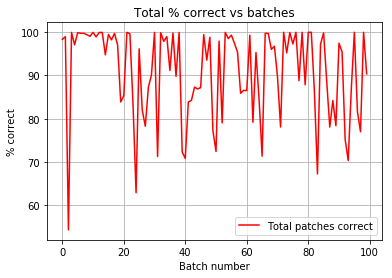

In [48]:
os.chdir(path_fig)
plt.figure(figsize=(9, 6))
fig = plt.figure()
plt.plot(total_plot[:100],c='r', label='Total patches correct')
plt.legend(loc='lower right')
plt.title('Total % correct vs batches')
plt.xlabel('Batch number')
plt.ylabel('% correct')
plt.grid()
fig.savefig('test.pdf', format="pdf")
plt.show()

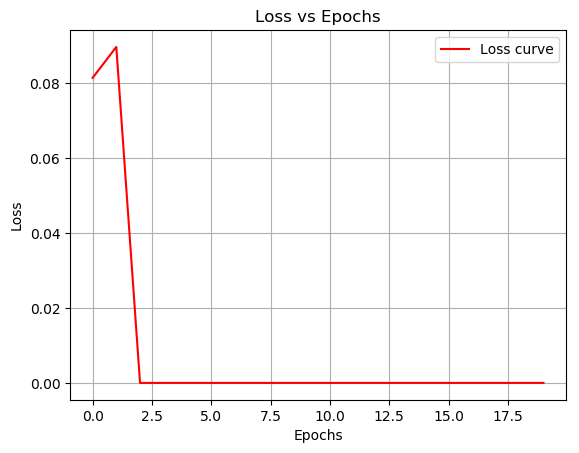

In [86]:
os.chdir(path_fig)
plt.figure(figsize=(9, 6))
fig = plt.figure()
plt.plot(loss_plot,c='r', label='Loss curve')
plt.legend(loc='upper right')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
fig.savefig('ResNet50_v58_20210211_2D_10dB_noise_autosave_loss.pdf', format="pdf")
plt.show()

### LIVE inferencing

In [138]:
# !python3 /home/david/sigMF_ML/gnuradio/record_live.py

#### 2D tensor with 300 noise
vodeson - 10
lora250 - 0
lora125 - 
click - 10
sado - 4ish
light - 
tyt - 
GD55
nfm - 


###  TESTING

[INFO] [UHD] linux; GNU C++ version 7.5.0; Boost_106501; UHD_3.15.0.0-62-g7a3f1516
[INFO] [B200] Detected Device: B205mini
[INFO] [B200] Operating over USB 3.
[INFO] [B200] Initialize CODEC control...
[INFO] [B200] Initialize Radio control...
[INFO] [B200] Performing register loopback test... 
[INFO] [B200] Register loopback test passed
[INFO] [B200] Setting master clock rate selection to 'automatic'.
[INFO] [B200] Asking for clock rate 16.000000 MHz... 
[INFO] [B200] Actually got clock rate 16.000000 MHz.
[INFO] [B200] Asking for clock rate 25.000000 MHz... 
[INFO] [B200] Actually got clock rate 25.000000 MHz.
[INFO] [MULTI_USRP]     1) catch time transition at pps edge
[INFO] [MULTI_USRP]     2) set times next pps (synchronously)
gr::log :INFO: sink0 - No core:datetime found, using host ts instead
OOOOOinference file name =  test1.sigmf-meta
iq_read_test live
gpu_test live function
I length =  125000000
Q length =  125000000
25600 MSPS
gpu_test live IQ shape = torch.Size([12801, 9766

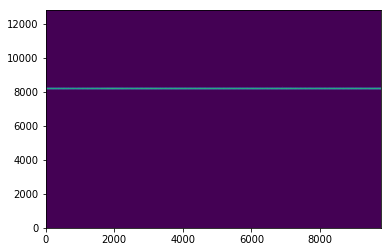

start_frequency =  428.0
sigmf_data =  (12800, 9766, 2)
frequency =  12800   time =  9766
seg_time =  43 seg_freq =  57
data_IQ shape =  (2451, 224, 224, 2)
testing counter =  tensor([2451]) seg_freq = tensor([57])
seg_freq =  tensor([57])


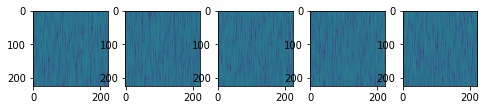

freq_increment =  219298.24561403508
TESTING inputs SHAPE =  torch.Size([1, 2451, 224, 224, 2])
input in   =  torch.Size([1, 2451, 224, 224, 2])
input out  =  torch.Size([2451, 224, 224, 2])
counter convert stuff =  tensor([2451]) <class 'numpy.ndarray'>
permuted shape =  torch.Size([2451, 2, 224, 224])
mean Freq =    435.89
std Freq =      0.00
length of inputs =  2451


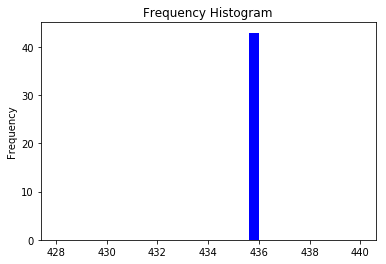

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 41.86%
LoRa 250 = 58.14%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2408
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************


In [42]:
msps = 25
center_freq_live = 428.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# testing new decimator
!python3 /home/david/sigMF_ML/gnuradio/record_live_25msps.py
# !python3 /home/david/sigMF_ML/gnuradio/record_live1msps.py
# usrp_data_collect_1MSPS()
data_IQ_list_val, meta_list_val = inference_read(msps)
testing_live(msps)
torch.cuda.empty_cache()

In [ ]:
msps = 5
center_freq_live = 433.0e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
!python3 /home/david/sigMF_ML/gnuradio/record_live_5msps.py
# !python3 /home/david/sigMF_ML/gnuradio/record_live1msps.py
# usrp_data_collect_1MSPS()
data_IQ_list_val, meta_list_val = inference_read(msps)
testing_live(msps)
torch.cuda.empty_cache()

[INFO] [UHD] linux; GNU C++ version 7.5.0; Boost_106501; UHD_3.15.0.0-62-g7a3f1516
[INFO] [B200] Detected Device: B205mini
[INFO] [B200] Operating over USB 3.
[INFO] [B200] Initialize CODEC control...
[INFO] [B200] Initialize Radio control...
[INFO] [B200] Performing register loopback test... 
[INFO] [B200] Register loopback test passed
[INFO] [B200] Setting master clock rate selection to 'automatic'.
[INFO] [B200] Asking for clock rate 16.000000 MHz... 
[INFO] [B200] Actually got clock rate 16.000000 MHz.
[INFO] [B200] Asking for clock rate 25.000000 MHz... 
[INFO] [B200] Actually got clock rate 25.000000 MHz.
[INFO] [MULTI_USRP]     1) catch time transition at pps edge
[INFO] [MULTI_USRP]     2) set times next pps (synchronously)
gr::log :INFO: sink0 - No core:datetime found, using host ts instead
OOinference file name =  test1.sigmf-meta
iq_read_test live
gpu_test live function
I length =  5000000
Q length =  5000000
1024 MSPS
gpu_test live IQ shape = torch.Size([513, 9766, 2])
FINA

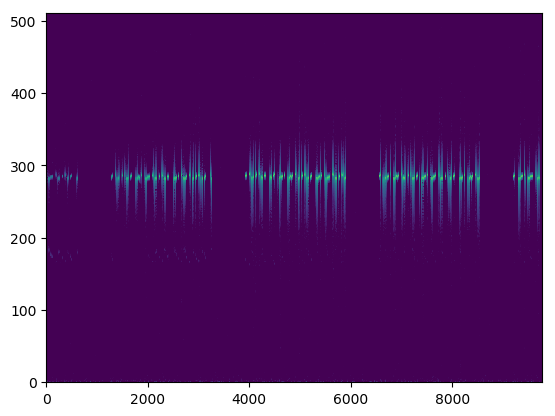

start_frequency =  433.65
sigmf_data =  (512, 9766, 2)
frequency =  512   time =  9766
seg_time =  43 seg_freq =  2
data_IQ shape =  (86, 224, 224, 2)
testing counter =  tensor([86]) seg_freq = tensor([2])
seg_freq =  tensor([2])


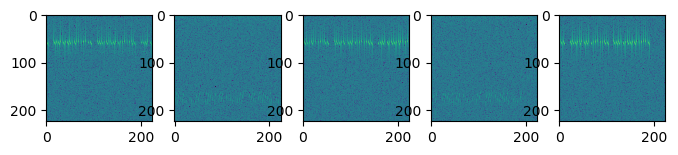

freq_increment =  250000.0
TESTING inputs SHAPE =  torch.Size([1, 86, 224, 224, 2])
input in   =  torch.Size([1, 86, 224, 224, 2])
input out  =  torch.Size([86, 224, 224, 2])
counter convert stuff =  tensor([86]) <class 'numpy.ndarray'>
permuted shape =  torch.Size([86, 2, 224, 224])
mean Freq =    433.90
std Freq =      0.00
length of inputs =  86


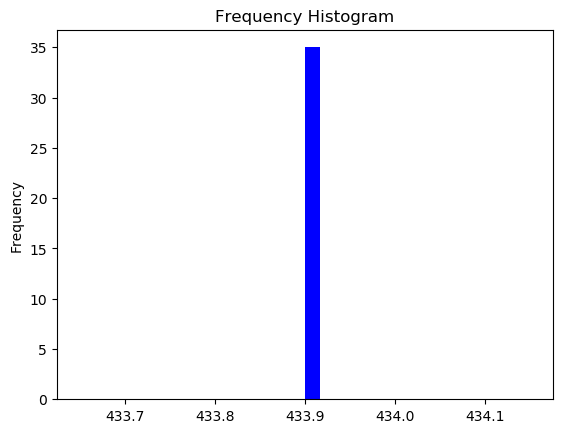

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 5.71%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 65.71%
YSF = 28.57%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  51
center fft matches =  0
TOTAL patch count =  86
***************************** Finished *********************************


In [116]:
msps = 1
center_freq_live = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
# testing new decimator
!python3 /home/david/sigMF_ML/gnuradio/record_live_25to1.py
# !python3 /home/david/sigMF_ML/gnuradio/record_live_1msps.py
# usrp_data_collect_1MSPS()
data_IQ_list_val, meta_list_val = inference_read(msps)
testing_live(msps)
torch.cuda.empty_cache()

In [ ]:
torch.cuda.empty_cache()

## testing pre-recorded files in /home/david/sigMF_ML/RF/RF_class/testing_data

inference file name =  UHF_sado_db1_test6.sigmf-meta
iq_read_test live
gpu_test live function
I length =  125000000
Q length =  125000000
25600 MSPS
gpu_test live IQ shape = torch.Size([12801, 9766, 2])
FINAL gpu_test LIVE IQ shape = torch.Size([12800, 9766, 2])
iq_read_test live imshow method


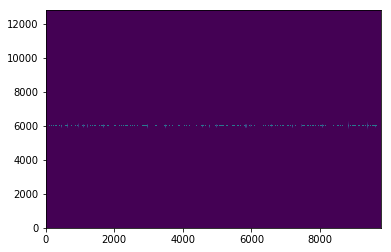

start_frequency =  428.0
sigmf_data =  (12800, 9766, 2)
frequency =  12800   time =  9766
seg_time =  43 seg_freq =  57
data_IQ shape =  (2451, 224, 224, 2)
testing counter =  tensor([2451]) seg_freq = tensor([57])
freq_increment =  219298.24561403508
TESTING inputs SHAPE =  torch.Size([1, 2451, 224, 224, 2])
input in   =  torch.Size([1, 2451, 224, 224, 2])
input out  =  torch.Size([2451, 224, 224, 2])
counter convert stuff =  tensor([2451]) <class 'numpy.ndarray'>
permuted shape =  torch.Size([2451, 2, 224, 224])
mean Freq =    433.80
std Freq =      0.11
length of inputs =  2451


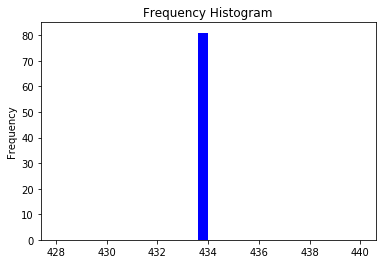

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 46.91
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 1.23%
light switch = 0.00%
YSF = 51.85%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  2370
center fft matches =  0
TOTAL patch count =  2451
***************************** Finished *********************************


In [43]:
msps = 25
center_freq_file = 428.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_25msps)
testing_file(msps)
torch.cuda.empty_cache()

inference file name =  UHF_clickndig_fob1_test1.sigmf-meta
iq_read_test live
gpu_test live function
I length =  25000000
Q length =  25000000
5120 MSPS
gpu_test live IQ shape = torch.Size([2561, 9766, 2])
FINAL gpu_test LIVE IQ shape = torch.Size([2560, 9766, 2])
start_frequency =  433.0
sigmf_data =  (2560, 9766, 2)
frequency =  2560   time =  9766
seg_time =  43 seg_freq =  11
data_IQ shape =  (473, 224, 224, 2)
testing counter =  tensor([473]) seg_freq = tensor([11])
freq_increment =  227272.72727272726
TESTING inputs SHAPE =  torch.Size([1, 473, 224, 224, 2])
input in   =  torch.Size([1, 473, 224, 224, 2])
input out  =  torch.Size([473, 224, 224, 2])
counter convert stuff =  tensor([473]) <class 'numpy.ndarray'>
permuted shape =  torch.Size([473, 2, 224, 224])
mean Freq =    433.68
std Freq =      0.00
length of inputs =  473


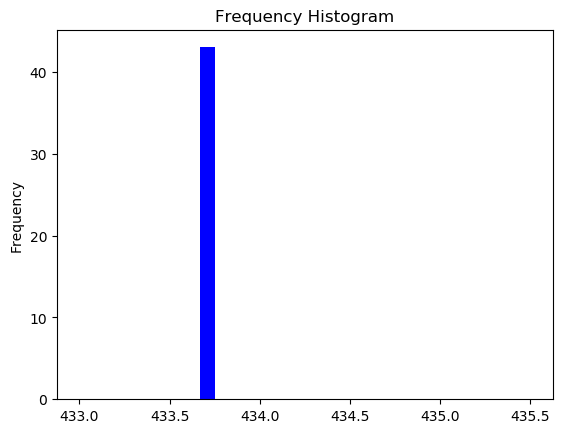

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 0.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 100.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  430
center fft matches =  0
TOTAL patch count =  473
***************************** Finished *********************************


In [42]:
msps = 5
center_freq_file = 433.00e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_5msps)
testing_file(msps)
torch.cuda.empty_cache()

inference file name =  lora125_test1.sigmf-meta
iq_read_test live
gpu_test live function
I length =  10000000
Q length =  10000000
1024 MSPS
gpu_test live IQ shape = torch.Size([513, 19532, 2])
FINAL gpu_test LIVE IQ shape = torch.Size([512, 19532, 2])
iq_read_test live imshow method


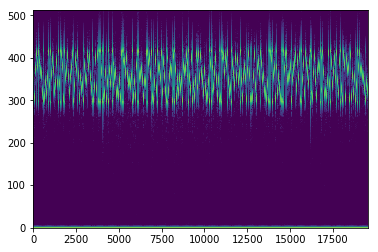

start_frequency =  433.65
sigmf_data =  (512, 19532, 2)
frequency =  512   time =  19532
seg_time =  87 seg_freq =  2
data_IQ shape =  (174, 224, 224, 2)
testing counter =  tensor([174]) seg_freq = tensor([2])
freq_increment =  250000.0
TESTING inputs SHAPE =  torch.Size([1, 174, 224, 224, 2])
input in   =  torch.Size([1, 174, 224, 224, 2])
input out  =  torch.Size([174, 224, 224, 2])
counter convert stuff =  tensor([174]) <class 'numpy.ndarray'>
permuted shape =  torch.Size([174, 2, 224, 224])
mean Freq =    433.90
std Freq =      0.00
length of inputs =  174


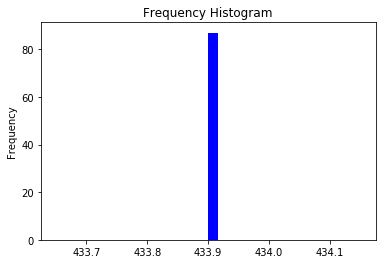

************************* Probabilities ********************************
----------------------------WAVEFORMS-----------------------------------
LoRa 125 = 100.00%
GD55 DMR = 0.00%
NFM = 0.00%
TYT = 0.00
Vodeson Doorbell = 0.00%
clickndig = 0.00%
Sado doorbell = 0.00%
LoRa 250 = 0.00%
light switch = 0.00%
YSF = 0.00%
------------------------------------------------------------------------
***************************** noise and fft ****************************
noise matches =  87
center fft matches =  0
TOTAL patch count =  174
***************************** Finished *********************************


In [44]:
msps = 1
center_freq_file = 433.65e6 # when SDR doing 25MSPS with center at 428MHz, or 433.65e6, 428.00e6
data_IQ_list_val, meta_list_val = inference_read_file(msps, path_test_1msps)
testing_file(msps)
torch.cuda.empty_cache()

In [166]:
torch.cuda.empty_cache()

#### Save and Load model data

#### save

In [333]:
# torch.save(model.state_dict(), PATH)

#### load

In [249]:
# device = torch.device("cuda:0")
# model = resnet50(2, 12)
# model.load_state_dict(torch.load(PATH))
# model.to(device)
# model.eval()

ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBottleNeckBlock(
            (blocks): Sequential(
              (0): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (1): ReLU()
              (2): Sequential(
                (conv): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [45]:
# # Print model's state_dict
# print("Model's state_dict:")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

In [46]:
# # Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

In [47]:
# # SAVE MODEL
# os.chdir(path_save)
# torch.save({
#            'epoch': epoch,
#            'model_state_dict': model.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'loss': loss,
#            }, path_save+rf_model)

In [48]:
# # LOAD MODEL
# checkpoint = torch.load(path_save+rf_model, map_location=device)


# # STATUS
# checkpoint.keys()

# epoch = checkpoint['epoch']
# model_state_dict = checkpoint['model_state_dict']
# optimizer_state_dict = checkpoint['optimizer_state_dict']
# loss = checkpoint['loss']

# optimizer_state_dict.keys()

# optimizer_state_dict['param_groups']

# loss

# model.load_state_dict(model_state_dict)   

In [49]:
# loss

In [50]:
# optimizer_state_dict.keys()